# Exploratory Data Analysis

In this notebook:
- We clean the data
- Engineer new features
- Explore the features' influence on adoption speed
- Export data with final features for further plotting
- Creating separate data sets for cats and dogs 
- Create dummies for further modeling
- Train-Test-Split
- Scale features where necessary for distance-based algorithms

In [166]:
# import necessary libraries
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# import sklearn-modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# import pickle for serialization
import pickle

# to import custom functions
import sys
import os

# Get the parent directory
parent_dir = os.path.dirname(os.getcwd()) 
# Add the parent directory to sys.path
sys.path.append(parent_dir)
# import our custom metrics function and our custom scorer (Cohen's Kappa)

from custom_functions import our_metrics
from custom_functions import get_kappa


pd.set_option('display.max_rows', 10)

In [167]:
# plot settings


In [168]:
df_raw = pd.read_csv("../data/petfinder-adoption-prediction/train/train.csv") #read in data
df_raw.columns = df_raw.columns.str.lower() #make column names lowercase

In [169]:
df_raw.head().T

,0,1,2,3,4
type,2,2,1,1,1
name,Nibble,No Name Yet,Brisco,Miko,Hunter
age,3,1,1,4,1
breed1,299,265,307,307,307
breed2,0,0,0,0,0
...,...,...,...,...,...
videoamt,0,0,0,0,0
description,Nibble is a 3+ month old ball of cuteness. He ...,I just found it alone yesterday near my apartm...,Their pregnant mother was dumped by her irresp...,"Good guard dog, very alert, active, obedience ...",This handsome yet cute boy is up for adoption....
petid,86e1089a3,6296e909a,3422e4906,5842f1ff5,850a43f90
photoamt,1.0,2.0,7.0,8.0,3.0


In [170]:
df_dropped = df_raw.drop(["state","petid","rescuerid","name"],axis=1) # Drop some columns that are not needed

## First look at target variable and bivariate distributions

In [171]:
df_dropped.adoptionspeed.value_counts(normalize=True) #Distribution of our classes. Relatively balanced! 

# Class 0 (Adopted on day of listing) will later be merge into class 1 (Adopted within the first week) since there are only few instances
# Also, it is unlikely that pets with certain properties are predictably adopted on day 1 (instead of day 2-7). Its more likely that it is just by chance

adoptionspeed
4    0.279931
2    0.269259
3    0.217368
1    0.206096
0    0.027346
Name: proportion, dtype: float64

In [172]:
#bivariate crosstabs with dependant and each independent variable one by one
for column_name in df_dropped.columns:
    print(pd.crosstab(df_dropped[column_name], df_dropped["adoptionspeed"],normalize="index"))
    print("____________")

adoptionspeed         0         1         2         3         4
type                                                           
1              0.020905  0.176463  0.266109  0.239670  0.296852
2              0.034980  0.241218  0.272992  0.190934  0.259875
____________
adoptionspeed         0         1         2         3         4
age                                                            
0              0.055866  0.279330  0.245810  0.217877  0.201117
1              0.023438  0.279080  0.327257  0.221788  0.148438
2              0.032829  0.246931  0.319726  0.223523  0.176991
3              0.022380  0.207528  0.298067  0.232960  0.239064
4              0.021641  0.190261  0.238954  0.234445  0.314698
..                  ...       ...       ...       ...       ...
168            0.000000  0.000000  0.000000  1.000000  0.000000
180            0.000000  0.000000  0.000000  0.500000  0.500000
212            0.000000  0.000000  0.000000  0.666667  0.333333
238            0.000000  0.

We assume some patterns but there are no clear and easy univariate ways to determine the adoption speed

A few questions and feature engineering ideas arose:

- Some patterns we find might be different for cats and dogs.
- Check if a pure-breed vs mixed breed feature can be created
- Shall we bin the age to get rid of the outliers?
- The quantity column is tricky. If there are more animals listed in one profile (at a certain point) the adoption speed will decrease because it takes time until they all are adopted. However, dropping all rows with quantity > 1 would mean that we loose 23% of data and would alter the age distribution (many profiles of quantity > 1 animals are newborn litters with very low age).
- Speaking of age: There seem to be many interactive effects with age. For example we thought that vaccinated and dewormed animals would have a higher adoption speed. That did not hold true though, sine young animals have high adoption rate but are often not (yet) vaccinated.

In [173]:
pd.crosstab(df_dropped.quantity, df_dropped.adoptionspeed)#, normalize="index")

adoptionspeed,0,1,2,3,4
quantity,,,,,
1,331,2439,3163,2552,3080
2,35,290,362,307,428
3,20,158,181,148,219
4,13,106,129,97,186
5,7,42,90,65,129
...,...,...,...,...,...
15,0,1,0,1,2
16,0,0,2,0,1
17,0,0,2,1,0


## Feature Engineering

### Fur Color and Breed

In [174]:
df_color_breed = df_dropped[["color1", "color2", "color3", "breed1", "breed2", "type"]]

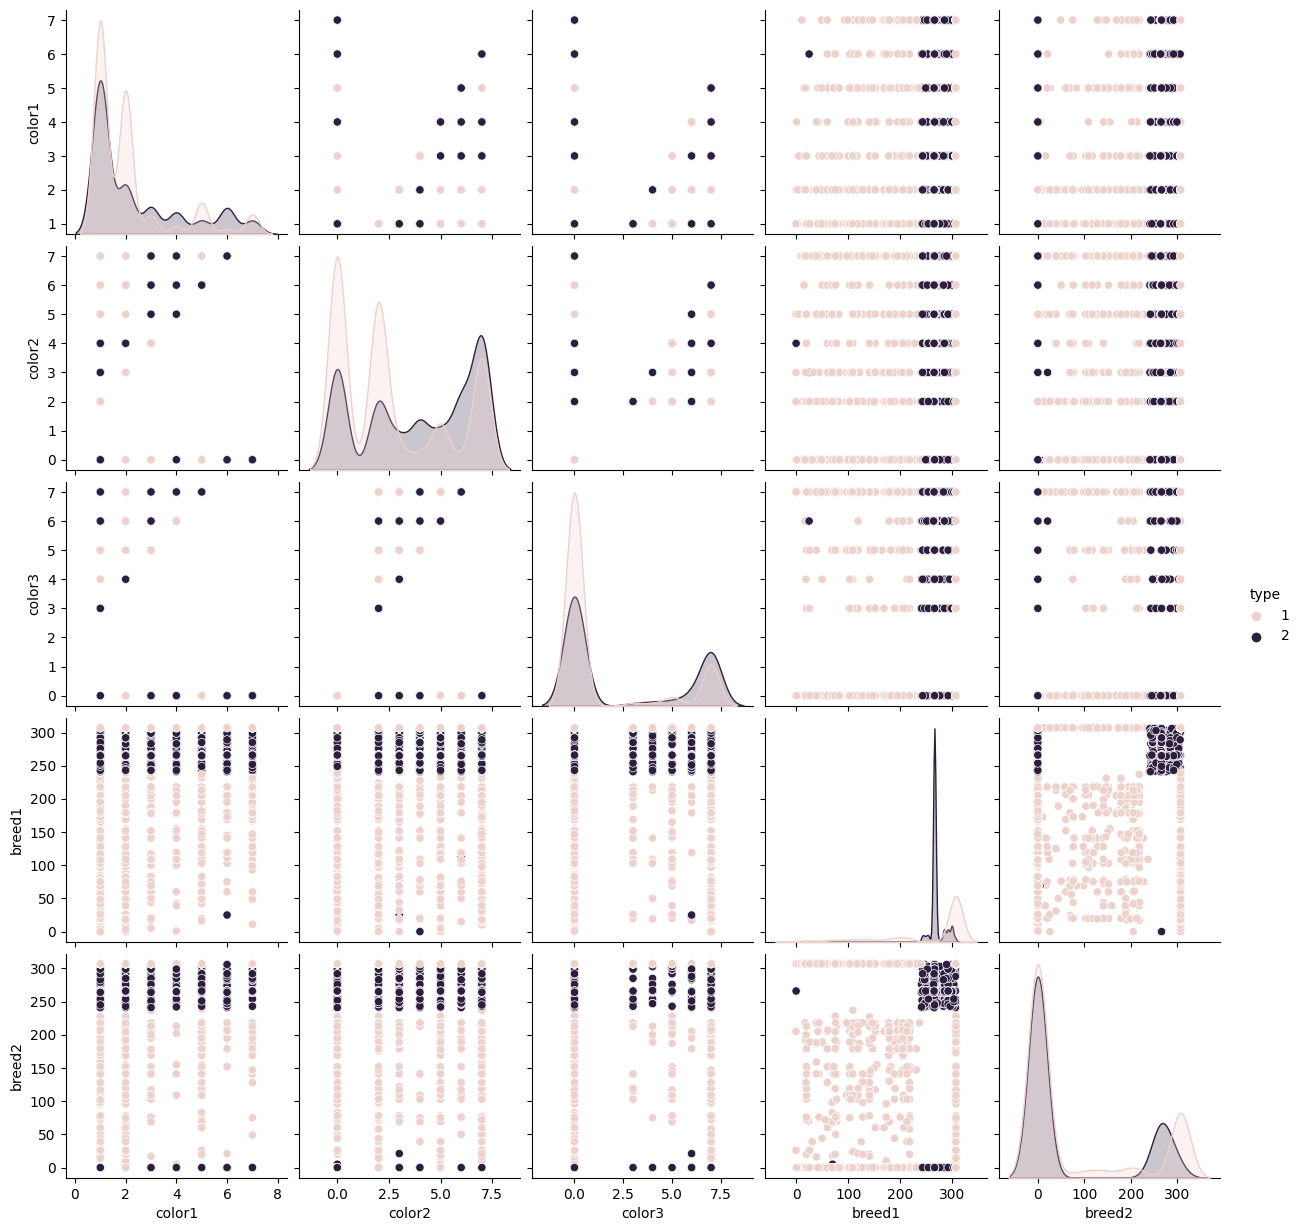

In [175]:
# look at the distribution of colors by breeds and types
df_color_breed = df_dropped[["color1", "color2", "color3", "breed1", "breed2", "type"]]
sns.pairplot(df_color_breed, hue="type");


If an animal has the color black (1), the colorcode (1) is always used in the color1 column. Or generally for a multi-color animal the lowest colorcode goes into column1. This explains the triangular shapes below. 

### Color Pattern: 

1 "Black"
2 "Brown"
3 "Golden"
4 "Yellow"
5 "Cream"
6 "Gray"
7 "White"

The color feature is filled in numerical order: color1 < color2 < color3 (except for 0),it is not sorted by primary color, therefore
- dark pattern = (1,0,0), (2,0,0), (6,0,0), (1,2,0), (1,6,0), (1,2,6), (2,6,0)
- light pattern = (3,0,0), (4,0,0), (5,0,0), (7,0,0), (3,4,0), (3,5,0), (3,7,0), (3,4,5), (3,4,7), (3,5,7), (4,5,0), (4,5,7), (4,7,0), (5,7,0)
- mixed pattern = else

In [176]:
#engineering the feature color_pattern (dark = 0, light = 1, mixed = 2)
patternlist = []
for colorcode in (df_dropped.color1.astype(str) + df_dropped.color2.astype(str) + df_dropped.color3.astype(str)):
    if colorcode in ("100","200","600","120","160","126","260"):
        patternlist.append(0) # 0 = dark color pattern
    elif colorcode in ("300", "400", "500", "700", "340", "350", "370", "345", "347", "357", "450", "457", "470", "570"):
        patternlist.append(1) # 1 = light color pattern
    else:
        patternlist.append(2) # 2 = mixed color pattern

df_dropped["color_pattern"] = patternlist

In [177]:
# distribution of the newly created color patterns...
df_dropped[["color_pattern"]].value_counts()

color_pattern
2                7533
0                4598
1                2862
Name: count, dtype: int64

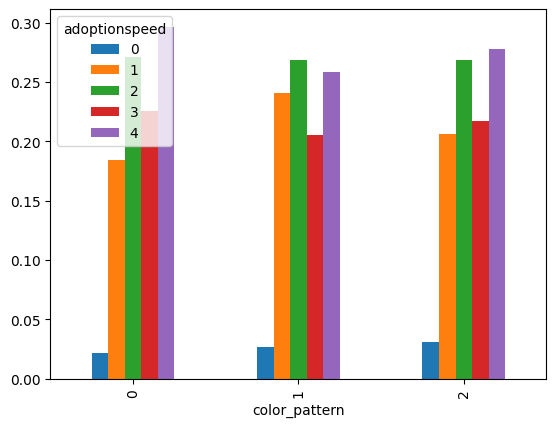

In [178]:
# ...and their distribution by adoption speed, normalized by color pattern
pd.crosstab(df_dropped["color_pattern"],df_dropped["adoptionspeed"],normalize='index').plot.bar();

the distribution does not indicates that pets' fur color influences adoption speed

### Breeds: 

mixed breed/no breed pets are dominant in the data, supporting the idea to engineer a mixed vs. pure breed feature
- mixed breed cats = domestic short hair (266), domestic medium hair (265), domestic long hair (264) are considered mixed breeds, also breed1 =! breed2 is mixed
- mixed breed dogs = category 307 or different entries in breed1 and breed2 column. 
- pure breed cats and dogs = breed2=0 & breed1 != 307, 264, 265, 266

In [179]:
df_dropped.query('breed1 == breed2 and breed1 != 307 and breed1 != 264 and breed1 != 265 and breed1 != 266').breed1.value_counts()

# There are some instances where pure bred animals have the same entry in breed1 and breed2 column. This needs to be taken into account.    

breed1
179    10
292     9
299     8
243     8
205     8
       ..
270     1
152     1
19      1
267     1
303     1
Name: count, Length: 43, dtype: int64

In [180]:
df_dropped['breed_type'] = np.where((((df_dropped["breed2"] == 0) | \
                                       (df_dropped["breed1"] == df_dropped["breed2"])) & (df_dropped.breed1 != 307) \
                                          & (df_dropped.breed1 != 264) & (df_dropped.breed1 != 265) & (df_dropped.breed1 != 266)), 0, 1)

# Complicated but it works :) 0 = pure-bred 1 = mixed-bred

In [181]:
#distribution of the newly created breed type...
df_dropped.breed_type.value_counts()

breed_type
1    12850
0     2143
Name: count, dtype: int64

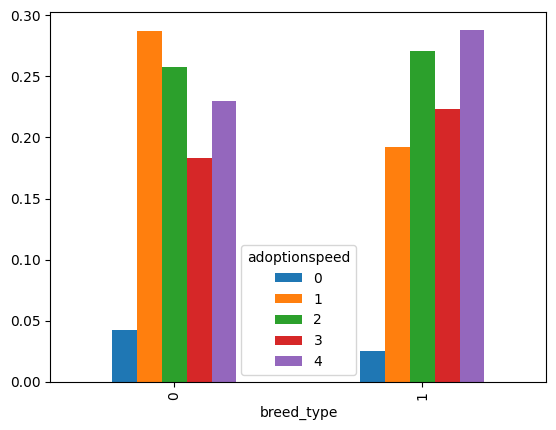

In [182]:
#...and their distribution by adoption speed, normalized by breed type  

pd.crosstab(df_dropped["breed_type"],df_dropped["adoptionspeed"],normalize="index").plot.bar();

Pure-bred animals have a faster adoption speed. However...

In [183]:
pd.crosstab([df_dropped.type, df_dropped.breed_type], df_dropped.adoptionspeed,normalize='index')

adoptionspeed           0         1         2         3         4
type breed_type                                                  
1    0           0.046193  0.317365  0.278015  0.204448  0.153978
     1           0.016659  0.152808  0.264110  0.245584  0.320839
2    0           0.037988  0.250513  0.233060  0.157084  0.321355
     1           0.034483  0.239681  0.279599  0.196535  0.249703

... this is only true for dogs and quite the opposite for cats!


### Vaccinated and Dewormed

vaccinated/dewormed = 3 means not known, and we assume it to be equal to not vaccinated/dewormed:
if it is unknown whether the animal is vaccinated/dewormed, vaccines and deworming treatment will need to be repeated.
We therefore replace category encode 3 into 2

In [184]:
df_dropped['vaccinated'] = df_dropped['vaccinated'].replace(3,2)
df_dropped['dewormed'] = df_dropped['dewormed'].replace(3,2)

the features vaccinated and dewormed are highly correlated and it most likely makes sense to combine them into one feature with 
three categories: fully vaccinated and dewormed (0), either only vaccinated or dewormed (1), and neither vaccinated or dewormed (2) 

In [185]:
# create a list of our conditions
conditions = [
    ((df_dropped['vaccinated'] == 1) & (df_dropped['dewormed'] == 1)),
    ((df_dropped['vaccinated'] == 1) & (df_dropped['dewormed'] == 2)),
    ((df_dropped['vaccinated'] == 2) & (df_dropped['dewormed'] == 1)),
    ((df_dropped['vaccinated'] == 2) & (df_dropped['dewormed'] == 2))
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df_dropped['vaccinated_dewormed'] = np.select(conditions, values)

In [186]:
#distribution of the newly created feature...
df_dropped['vaccinated_dewormed'].value_counts()

vaccinated_dewormed
2    6332
0    5634
1    3027
Name: count, dtype: int64

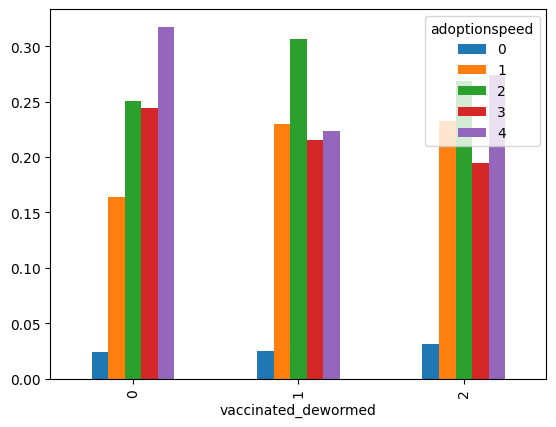

In [187]:
# and its' distribution by adoption speed
pd.crosstab(df_dropped['vaccinated_dewormed'], df_dropped['adoptionspeed'], normalize='index').plot.bar();

The adoption speed of shelter pets does not significantly differ by their vaccination/deworming status.

### Pets' Age


Feature Engineering Age:
- newborn: 0-3 months higher adoption speeds up to this age on average (0)
- puppy/kitten 4-12 (1)
- adult 13-72 month (2)
- senior: >= 73 (3)


Hypothesis:
- in general, younger animals are adopted faster
- age is more significant for dogs' adoption then for cats', adult or old dogs are in the shelter more frequently then adult or old cats

In [188]:
# due to a very low number of instances in adoption speed 0, we will combine cat. 0 and 1
df_dropped.adoptionspeed = df_dropped.adoptionspeed.replace(0,1)

In [189]:
# feature engineering age
# create a list of our conditions
conditions_age = [
    ((df_dropped['age'] >= 0) & (df_dropped['age'] <= 3)),
    ((df_dropped['age'] >= 4) & (df_dropped['age'] <= 12)),
    ((df_dropped['age'] >= 13) & (df_dropped['age'] <= 72)),
    (df_dropped['age'] >= 73)
    ]

# create a list of the values we want to assign for each condition
values_age = [0, 1, 2, 3]

# create a new column and use np.select to assign values to it using our lists as arguments
df_dropped['age_bin'] = np.select(conditions_age, values_age)

In [190]:
# distribution of age among the new categories in the data...
df_dropped.age_bin.value_counts()

age_bin
0    7952
1    4259
2    2518
3     264
Name: count, dtype: int64

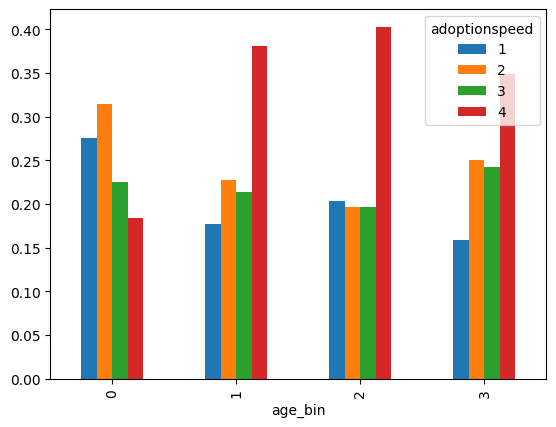

In [191]:
# and distribution by adoption speed, normalized by age bins
pd.crosstab(df_dropped['age_bin'], df_dropped['adoptionspeed'], normalize='index').plot.bar();

Fast adoption (within the first week and the first month) are dominant among puppies and kitten, while this trend is reversed among other age groups. Thus, our hypothesis is correct: younger animals are adopted faster.

### Feature Video Amount

In [192]:
#feature distribution
df_dropped.videoamt.value_counts()

videoamt
0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: count, dtype: int64

In [193]:
# feature distribution by adoption speed, normalized by video amount
pd.crosstab(df_dropped["videoamt"], df_dropped["adoptionspeed"],normalize="index")

adoptionspeed,1,2,3,4
videoamt,,,,
0,0.234413,0.267633,0.215272,0.282683
1,0.218225,0.311751,0.261391,0.208633
2,0.217391,0.315217,0.315217,0.152174
3,0.166667,0.361111,0.194444,0.277778
4,0.066667,0.200000,0.333333,0.400000
5,0.142857,0.285714,0.428571,0.142857
6,0.250000,0.000000,0.250000,0.500000
7,0.000000,1.000000,0.000000,0.000000
8,0.000000,0.000000,0.500000,0.500000


drop video column: hardly any animals with videos, from above crosstab/count plot: for those with video all adoption speeds apparent


In [194]:
# drop video column: hardly any animals with videos, from above crosstab/count plot: for those with video all adoption speeds apparent
df_dropped.drop(["videoamt","color1", "color2", "color3","breed1","breed2", "vaccinated", "dewormed"], axis=1, inplace=True)

### Feature Adoption Fee
we create a binary feature of adoption fee: no fee = 0, fee = 1

In [195]:
df_dropped["fee_bin"] = np.where((df_dropped["fee"] == 0), 0, 1)


In [196]:
df_dropped.fee_bin.value_counts()

fee_bin
0    12663
1     2330
Name: count, dtype: int64

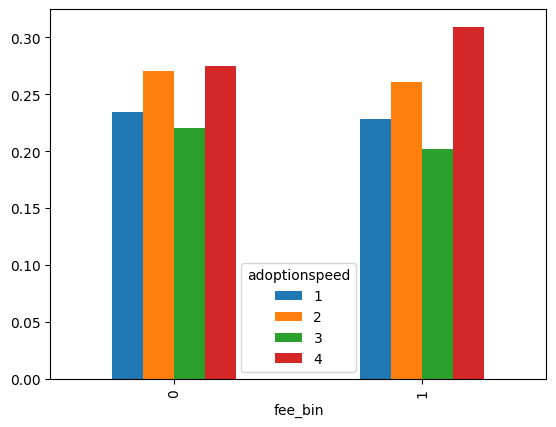

In [197]:
# distribution by adoption speed, normalized by fee bins 
pd.crosstab(df_dropped['fee_bin'], df_dropped['adoptionspeed'], normalize='index').plot.bar();

The adoption speed distribution does not vary between required adoption fee and free adoption.

In [198]:
df_dropped.drop(["age","fee"], axis=1, inplace=True) #dropping age and fee column because new binned columns were created

### Feature Photo Amount
- bin/cap photo amount column to address it's highly skewed distribution
- does the amount of photos added to the animal listing influence the adoption speed?

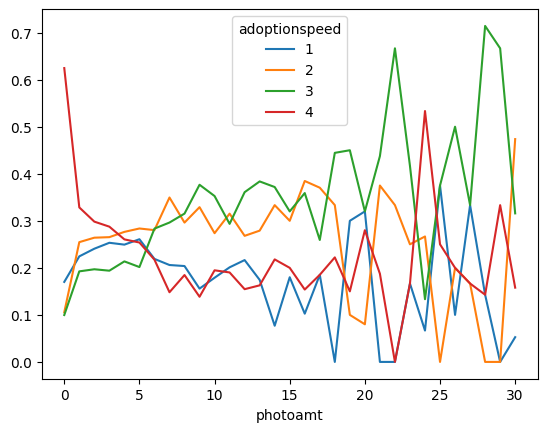

In [199]:
# distribution of photo amoung by adoption speed
pd.crosstab(df_dropped["photoamt"], df_dropped["adoptionspeed"],normalize="index").plot.line();

Added photos of shelter pets positively influence adoption speed

In [200]:
# percentage of listings with more then 10 photos
df_dropped.query("photoamt >10").adoptionspeed.value_counts().sum()/df_dropped.shape[0]

0.04882278396585073

In [201]:
# bin photoamt >10 to 11 to get rid of tail
df_dropped["photoamt_11"] = np.where((df_dropped["photoamt"] < 11), df_dropped["photoamt"], 11)

In [202]:
df_dropped.photoamt_11.value_counts()

photoamt_11
1.0     3075
2.0     2518
3.0     2511
5.0     2147
4.0     1881
        ... 
7.0      432
0.0      341
8.0      314
9.0      231
10.0     190
Name: count, Length: 12, dtype: int64

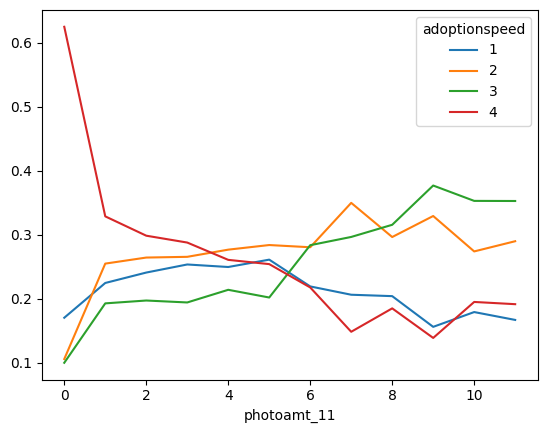

In [203]:
pd.crosstab(df_dropped["photoamt_11"], df_dropped["adoptionspeed"],normalize="index").plot.line();

In this plot, the positive effect of adding a photo as opposed to no photos is visible even better. Recommendation to increase Adoption Speed:
add pictures, ideally $\geq 4$ (starting from that amount, Adoption speed 4 is not the largest subset anymore)

### Feature Description Length
to utilize the description column, we will create a feature holding the length of the description string, the hypothesis being
that animals with a more detailed description will be adopted faster. 

In [204]:
#check where description col. contains missing values
(df_dropped[df_dropped['description'].isnull()])

,type,gender,maturitysize,furlength,sterilized,health,quantity,description,photoamt,adoptionspeed,color_pattern,breed_type,vaccinated_dewormed,age_bin,fee_bin,photoamt_11
96,2,2,3,3,2,1,1,NaN,3.0,1,0,0,0,2,0,3.0
605,2,1,2,2,2,1,1,NaN,3.0,4,2,1,2,0,0,3.0
1098,2,1,1,1,3,1,1,NaN,1.0,4,0,1,0,1,0,1.0
2109,1,2,2,2,1,1,2,NaN,3.0,2,2,1,0,2,0,3.0
4218,2,1,3,1,1,1,1,NaN,5.0,2,1,1,0,3,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272,1,1,2,2,3,2,1,NaN,0.0,4,1,1,2,0,0,0.0
11365,2,1,3,1,1,1,1,NaN,1.0,2,0,0,0,2,0,1.0
11890,1,2,2,1,2,1,2,NaN,1.0,4,0,1,2,0,0,1.0
12713,1,1,3,2,1,1,1,NaN,4.0,1,1,0,0,1,1,4.0


In [205]:
# create feature of description length (character count)
df_dropped['description_char'] = df_dropped.description.str.len()

#check if this worked
df_dropped.description_char.value_counts()

description_char
12.0      207
14.0       75
122.0      65
16.0       63
88.0       59
         ... 
1376.0      1
1227.0      1
1723.0      1
2119.0      1
1447.0      1
Name: count, Length: 1478, dtype: int64

In [206]:
# fill missing char count with 0
df_dropped['description_char'] = df_dropped['description_char'].fillna(0)

In [207]:
# drop description column
df_dropped.drop(['description'], inplace=True, axis=1)

the description length does not seem to influence the adoption speed

### How to handle multiple animal listings (quantity feature)
some oberservations do not refer to one single animal but a group (assumption: most often one littre, which is supported by the finding that most of these listings have animals in age category 0 or 1 (0-3 months and 4-12 months). Possible strategies:
- drop the listings as faulty data (+ the faulty features of these observations would not influence the model)
- treat these observations as one single animal, introduce another category for misleading features (like mix for colorpattern)
- split from the data and model separately in a later iteration

In [208]:
# age distribution of multiple listings
df_dropped.query("quantity>1").age_bin.value_counts()

age_bin
0    2433
1     665
2     308
3      22
Name: count, dtype: int64

In [209]:
# how much data of animals aged 0 and 1 would we lose by dropping the multiple listings?

print(f'we would lose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[0]/df_dropped.age_bin.value_counts().iloc[0]).round(2)} percent of newborns.')
print(f'we would lose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[1]/df_dropped.age_bin.value_counts().iloc[1]).round(2)} percent of kittens/puppies.')
print(f'we would lose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[2]/df_dropped.age_bin.value_counts().iloc[2]).round(2)} percent of adults.')
print(f'we would lose {(df_dropped.query("quantity>1").age_bin.value_counts().iloc[3]/df_dropped.age_bin.value_counts().iloc[3]).round(2)} percent of seniors.')


# looking at the percentage, we would lose much more of newborns and puppies and kittens if we dropped multiple listings
# but does their distribution actually differ from the entire data (meaning would dropping them skew the distribution differently then it was before)?

we would lose 0.31 percent of newborns.
we would lose 0.16 percent of kittens/puppies.
we would lose 0.12 percent of adults.
we would lose 0.08 percent of seniors.


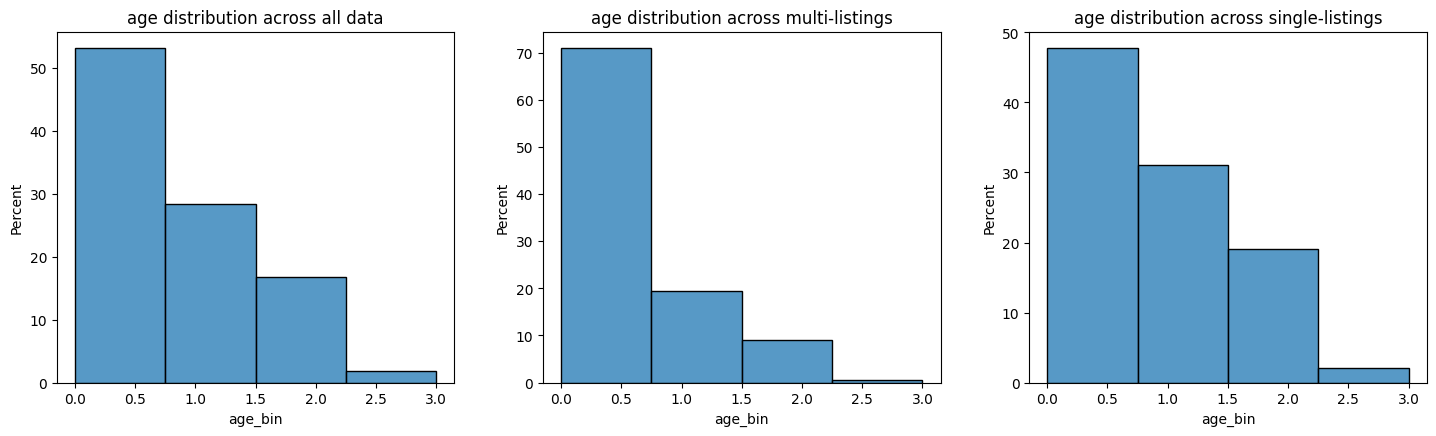

In [210]:
# comparing age distribution in the entire dataset and those we would drop:

fig,ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(ax=ax[0], data=df_dropped, x='age_bin', stat='percent', bins=4)
sns.histplot(ax=ax[1], data=df_dropped.query('quantity > 1'), x='age_bin', stat='percent', bins=4)
sns.histplot(ax=ax[2], data=df_dropped.query('quantity == 1'), x='age_bin', stat='percent', bins=4)
ax[0].set_title('age distribution across all data')
ax[1].set_title('age distribution across multi-listings')
ax[2].set_title('age distribution across single-listings')
fig.tight_layout(pad=3)



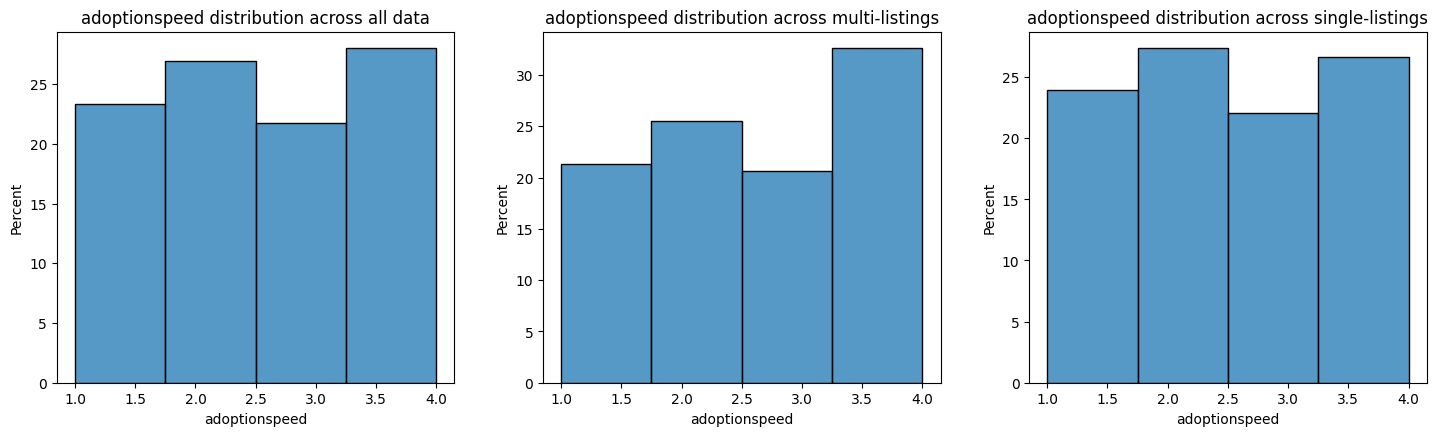

In [211]:
# comparing adoption speed distribution in the entire dataset and those we would drop:

fig,ax = plt.subplots(1,3,figsize=(15,5))
sns.histplot(ax=ax[0], data=df_dropped, x='adoptionspeed', stat='percent', bins=4)
sns.histplot(ax=ax[1], data=df_dropped.query('quantity > 1'), x='adoptionspeed', stat='percent', bins=4)
sns.histplot(ax=ax[2], data=df_dropped.query('quantity == 1'), x='adoptionspeed', stat='percent', bins=4)
ax[0].set_title('adoptionspeed distribution across all data')
ax[1].set_title('adoptionspeed distribution across multi-listings')
ax[2].set_title('adoptionspeed distribution across single-listings')
fig.tight_layout(pad=3)

In [212]:
# crosstab of quantity by adoption speed, normalized by quantity 
pd.crosstab(df_dropped.quantity, df_dropped.adoptionspeed, normalize='index')

adoptionspeed,1,2,3,4
quantity,,,,
1,0.239516,0.273498,0.220666,0.266321
2,0.228551,0.254571,0.215893,0.300985
3,0.245179,0.249311,0.203857,0.301653
4,0.224105,0.242938,0.182674,0.350282
5,0.147147,0.270270,0.195195,0.387387
...,...,...,...,...
15,0.250000,0.000000,0.250000,0.500000
16,0.000000,0.666667,0.000000,0.333333
17,0.000000,0.666667,0.333333,0.000000


We have no information about the characteristics of animals grouped into listings with more then one animal, so we can not use this column in the further modeling process. We therefore decide to treat multiple listings as faulty/ unknown data and delete these from our data. Our model will only be valid for predicting the adoption speed for one single animal. not for litters or other animal groups.

In [213]:
# Delete quantity > 1 and delete the column
df_dropped = df_dropped[df_dropped["quantity"]==1]
df_dropped = df_dropped.drop("quantity", axis=1)

## Feature Distribution by Adoption Speed

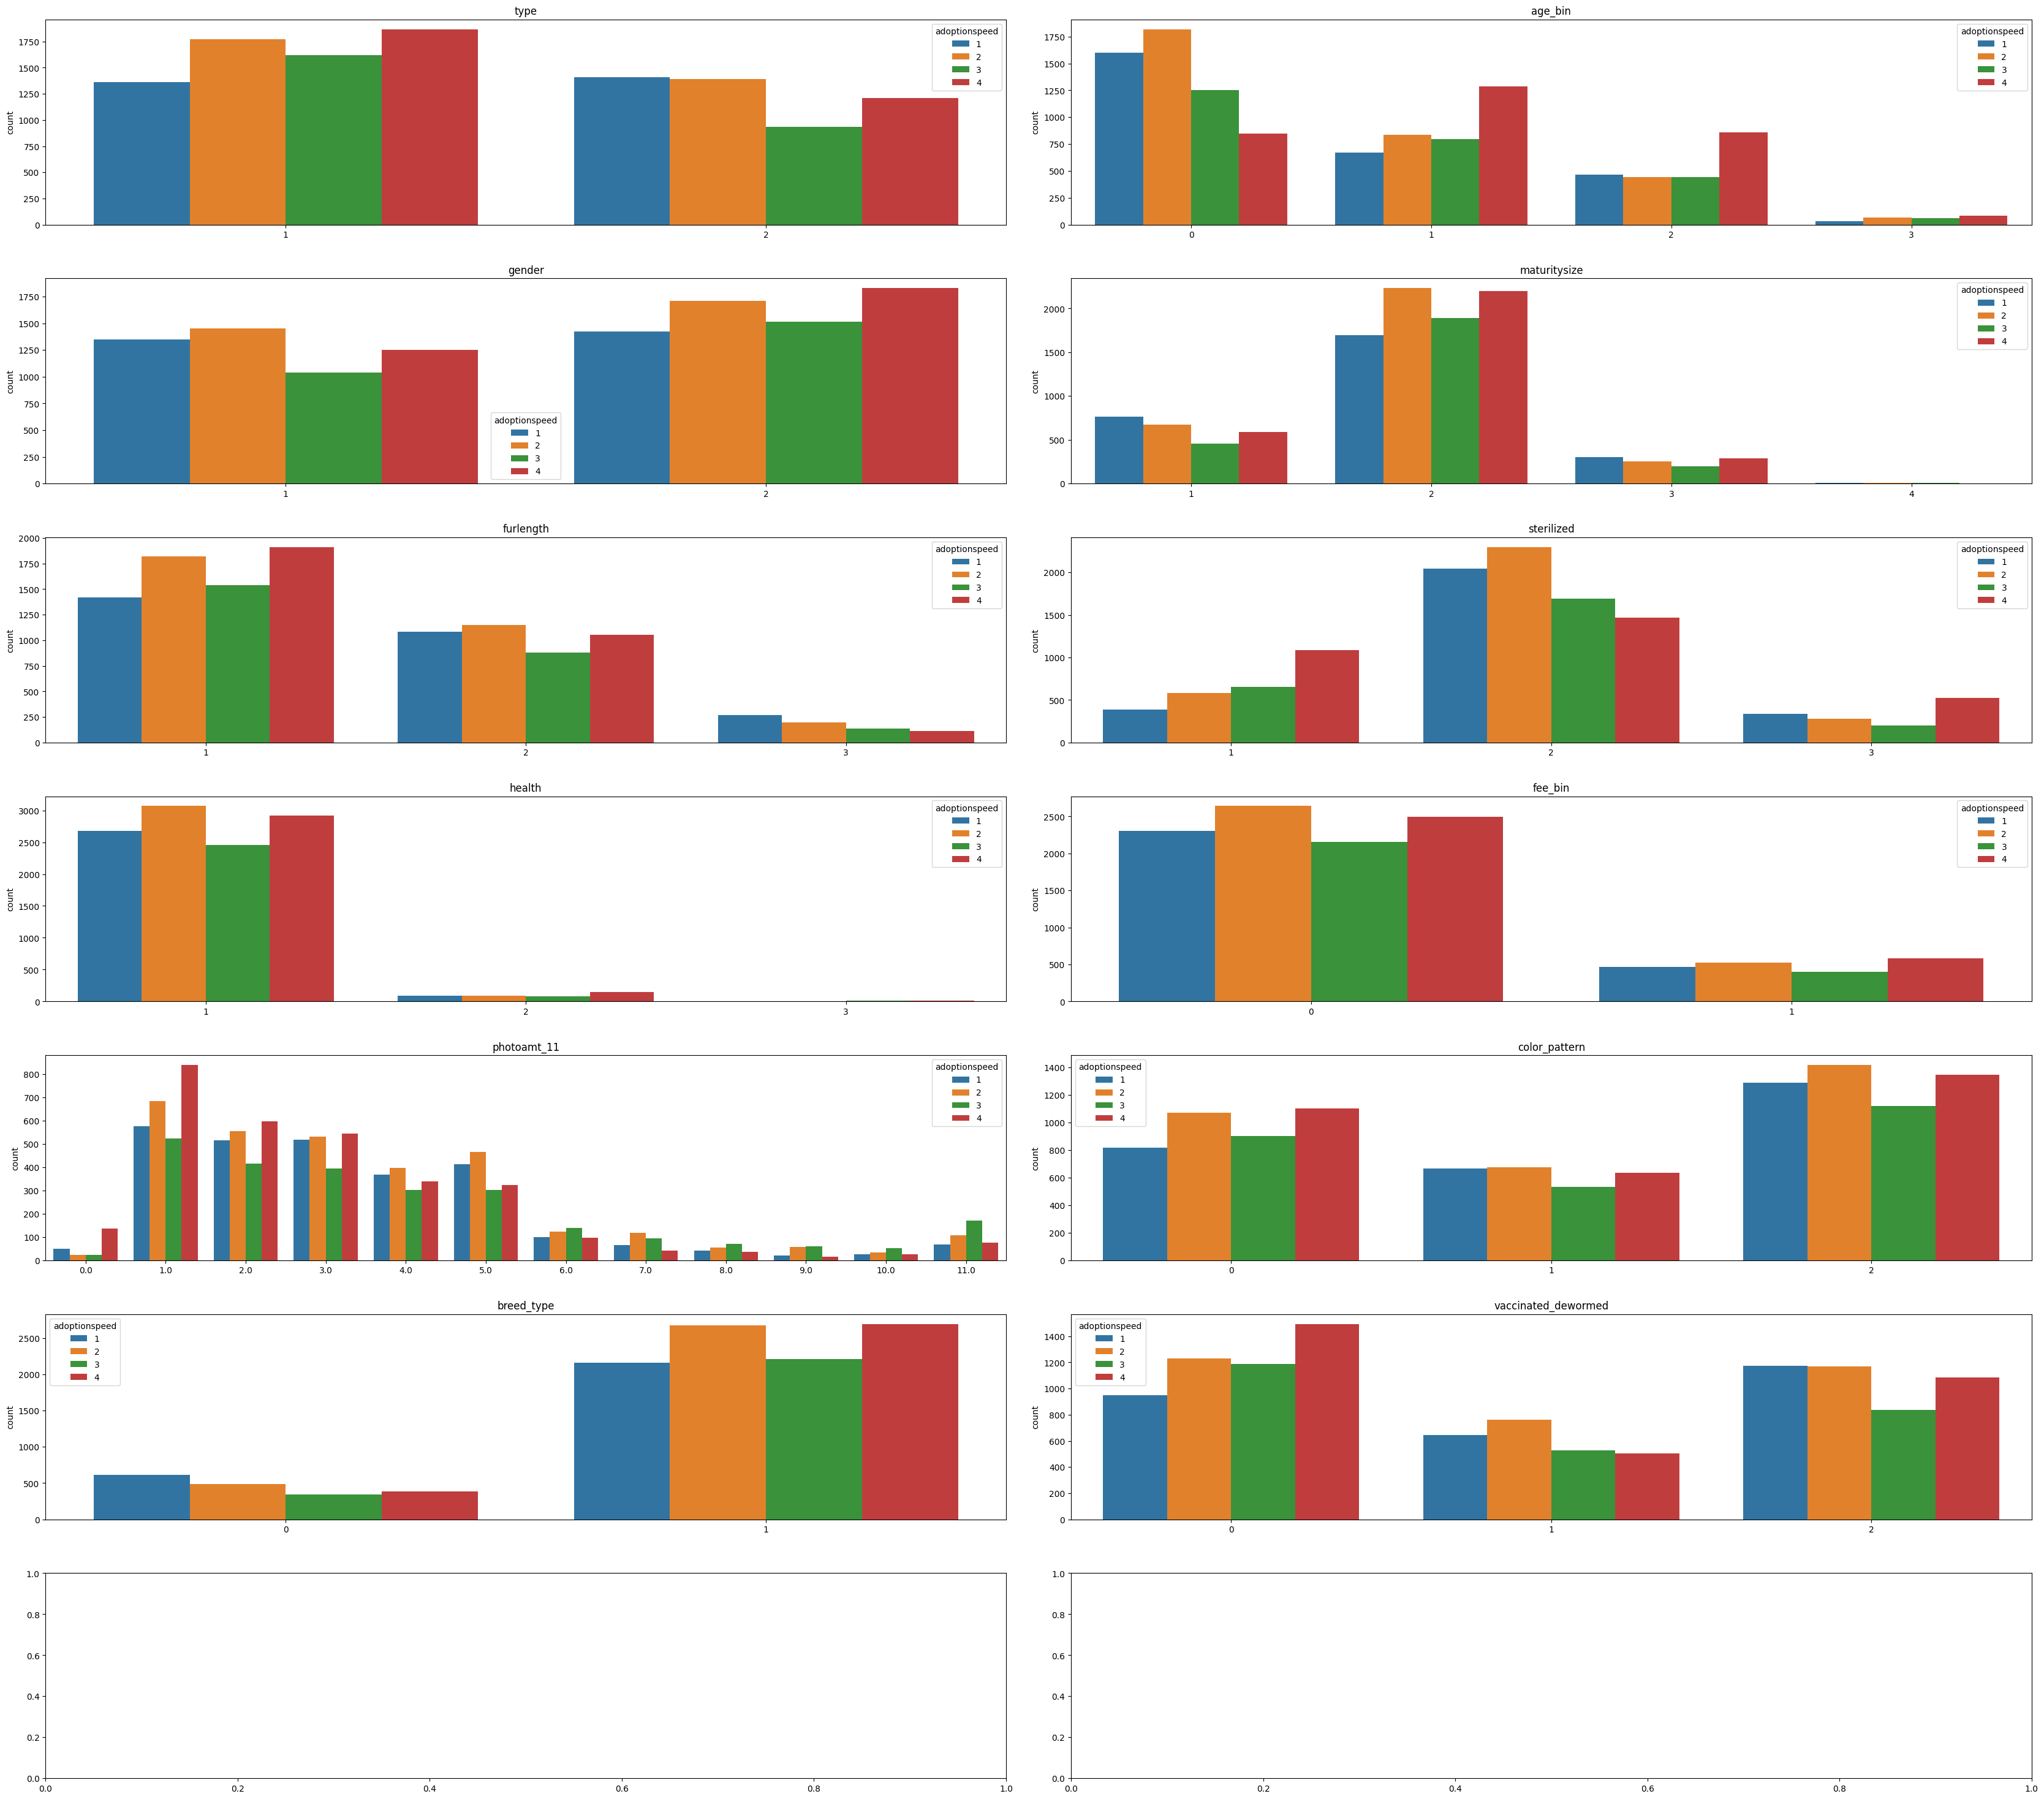

In [214]:
# Plot distribution of features 
histplot_features = ['type', 'age_bin', 'gender', 'maturitysize', 'furlength', 'sterilized', 'health', 'fee_bin', 'photoamt_11', 'color_pattern', 'breed_type', 'vaccinated_dewormed']

fig,ax = plt.subplots(7,2,figsize=(34,30))
count = 0
for item in histplot_features:
    sns.countplot(df_dropped, x=item, ax=ax[int(count/2)][count%2], hue='adoptionspeed').set(title=item, xlabel='')
    count += 1
#ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

#fig.savefig('../images/feature_histogram2.jpg')

## Correlation Heatmap

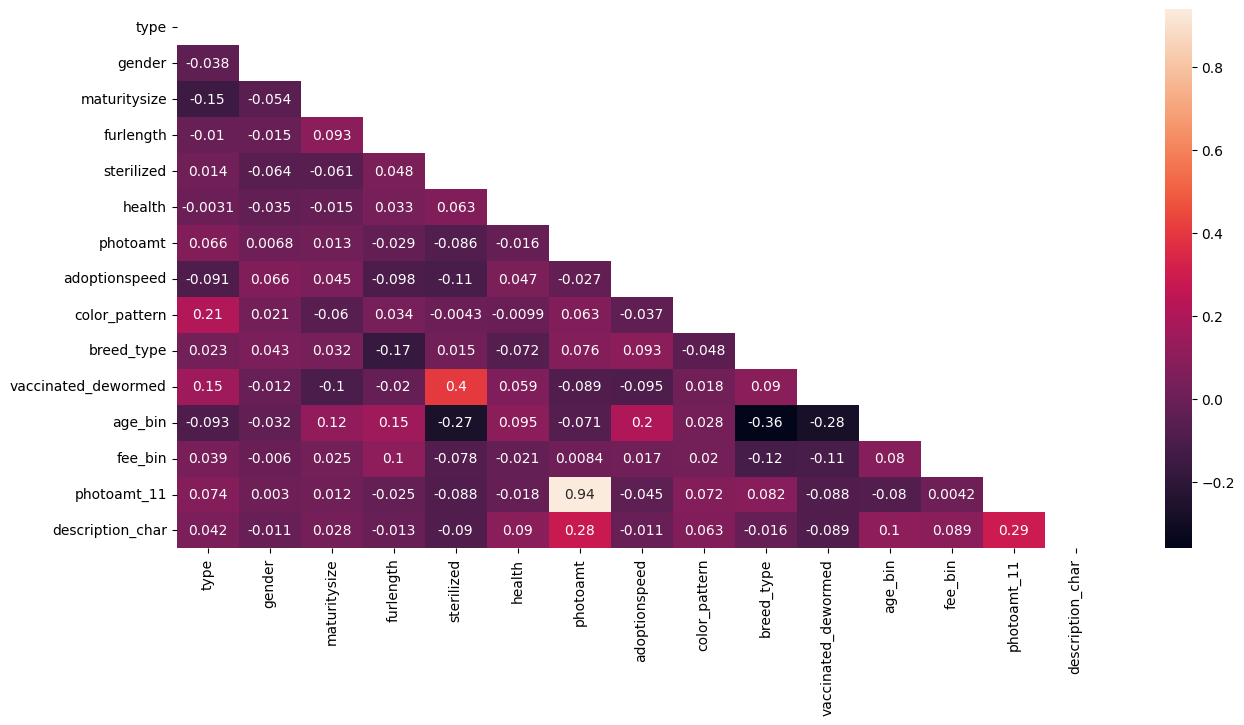

In [215]:
# plot the heatmap with final features:
final_features = df_dropped.columns.tolist()
corr_matrix = df_dropped[final_features].corr()

#creating mask
mask = np.triu(np.ones_like(corr_matrix.corr()))

#plotting a triangle correlation heatmap
plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, annot=True, mask=mask)
plt.show()

## Dummies for different models

- type: change type to 0,1 (substract 1)
- gender: change gender to 0,1 (substract 1),
- maturitry size: ordinal, substract 1, get dummy according to your model
- fur length: ordinal, substract 1, get dummy according to your model
- sterilization: replace unknown (3) with 2 (no), substract 1
- health: ordinal, substract 1, get dummy according to your model
- quantity: rescale
- description: drop for MVP
- photoamt: drop 
- colorpattern: get dummies 
- breed type: done
- vaccinated_dewormed: could be ordinal if you really want it to :)
- fee_bin: done
- age_bin: ordinal, rescale for distance-based models
- photoamt_11: ordinal, rescale
- description_len: drop
- description_char/description_words: ordinal, rescale if you want to include in model 


In [216]:
# change the type column to 0 and 1
df_dropped['type'] = df_dropped['type'] - 1

In [217]:
# change gender to 0, 1,2 from 1, 2, 3 
df_dropped['gender'] = df_dropped['gender'] - 1

In [218]:
# change the maturity size
df_dropped['maturitysize'] = df_dropped['maturitysize'] -1 

In [219]:
# convert the fur size
df_dropped['furlength'] = df_dropped['furlength'] -1 

In [220]:
# convert the health to 0,1,2
df_dropped['health'] = df_dropped['health'] -1 

In [221]:
# replace the 3 which is unknown with no
df_dropped['sterilized'] = df_dropped['sterilized'].replace(3,2)

In [222]:
# convert the sterilized to 0,1
df_dropped['sterilized'] = df_dropped['sterilized'] - 1

In [223]:
# drop columns that we donot need in the models
df_dropped = df_dropped.drop(['description', 'description_words'], axis=1, errors='ignore')

In [224]:
# drop columns that we do not need in the models
df_dropped = df_dropped.drop(['photoamt'], axis=1, errors='ignore')

## Export processed data frame for plots (df_eda.csv)

In [225]:
# make eda directory to store csv in
# only run once
#os.mkdir('data/petfinder-adoption-prediction/eda')

In [226]:
# export current status of df for eda
#pd.DataFrame(df_dropped).to_csv('data/petfinder-adoption-prediction/eda/df_eda.csv', index=False)

In [227]:
# make directory to store presentation charts in
#os.mkdir('../images/presentation')

## Create dummies and scale

In [228]:
# dummies for some columns: maturity size, fur length, health, color_pattern (first column is not dropped from the dummies)
dummy_list = ['maturitysize', 'furlength', 'health', 'color_pattern']
df_dummies = pd.get_dummies(df_dropped[dummy_list], columns=dummy_list, dtype=int)

In [229]:
# first dummy column dropped for the distance based algorithms
df_dummies_distance = pd.get_dummies(df_dropped[dummy_list], columns=dummy_list, dtype=int, drop_first=True)
# create the dataframe with the dropped first dummy column
df_processed_dropped_first =  pd.concat([df_dropped.drop(dummy_list,axis=1), df_dummies_distance],axis=1)

In [230]:
#processed dataframe with dummy columns where first column was not dropped
df_processed =  pd.concat([df_dropped.drop(dummy_list,axis=1), df_dummies],axis=1)

In [231]:
# define X with processed data that still has the all the dummy columns
X_processed = df_processed.drop('adoptionspeed', axis=1)

In [232]:
# define X with data that has the first dummy column dropped
X_dropped_first = df_processed_dropped_first.drop('adoptionspeed', axis=1)

In [233]:
#train test split with X_processed
y = df_processed["adoptionspeed"]
X_train_processed, X_test_processed, y_train, y_test = train_test_split(X_processed, y, random_state=42, stratify=y)

In [234]:
# train test split with the dataframe that has first dummy column removed
X_train_dropped_first, X_test_dropped_first, y_train, y_test = train_test_split(X_dropped_first, y, random_state=42, stratify=y)

In [235]:
minmax_scaler = MinMaxScaler()
# scaled the 3 features 
num_features = ['photoamt_11', 'age_bin', 'description_char']
#scaling with the processed data with all dummy columns
X_train_minmax_scaled_processed_1 = minmax_scaler.fit_transform(X_train_processed[num_features])
X_test_minmax_scaled_processed_1 = minmax_scaler.transform(X_test_processed[num_features])

X_train_minmax_scaled_processed = pd.concat([X_train_processed.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_minmax_scaled_processed_1,columns= num_features)],axis=1)
X_test_minmax_scaled_processed = pd.concat([X_test_processed.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_minmax_scaled_processed_1,columns= num_features)],axis=1)

In [236]:
# Serialize the scaler for the streamlit app:
pickle.dump(minmax_scaler, open('../06_Streamlit_App/scaler.sav', 'wb'))

In [237]:
# scaling the processed data with first dummy column removed
X_train_minmax_scaled_dropped_first_1 = minmax_scaler.fit_transform(X_train_dropped_first[num_features])
X_test_minmax_scaled_dropped_first_1 = minmax_scaler.transform(X_test_dropped_first[num_features])

X_train_minmax_scaled_dropped_first = pd.concat([X_train_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_minmax_scaled_dropped_first_1,columns= num_features)],axis=1)
X_test_minmax_scaled_dropped_first = pd.concat([X_test_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_minmax_scaled_dropped_first_1,columns= num_features)],axis=1)

In [238]:
X_train_minmax_scaled_dropped_first

,type,gender,sterilized,breed_type,vaccinated_dewormed,fee_bin,maturitysize_1,maturitysize_2,maturitysize_3,furlength_1,furlength_2,health_1,health_2,color_pattern_1,color_pattern_2,photoamt_11,age_bin,description_char
0,0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0.090909,1.000000,0.056573
1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0.454545,0.000000,0.057623
2,0,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0.181818,0.333333,0.077581
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.363636,0.333333,0.086134
4,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0.090909,0.000000,0.001801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8668,0,0,1,1,2,0,1,0,0,0,0,0,0,1,0,0.090909,0.000000,0.011255
8669,1,0,1,1,2,0,1,0,0,0,0,0,0,0,1,0.454545,0.000000,0.021309
8670,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0.090909,0.333333,0.008103
8671,1,1,1,1,2,0,0,1,0,0,0,0,0,0,1,0.454545,0.666667,0.069328


## Export Processed Data

In [239]:
# export processed data set to csv

# export features for tree-based models
pd.DataFrame(X_train_minmax_scaled_processed).to_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_processed.csv', index=False)
pd.DataFrame(X_test_minmax_scaled_processed).to_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_processed.csv', index=False)

# export features for distance-based models
pd.DataFrame(X_train_minmax_scaled_dropped_first).to_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_dropped_first.csv', index=False)
pd.DataFrame(X_test_minmax_scaled_dropped_first).to_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_dropped_first.csv', index=False)

# export target
pd.DataFrame(y_train).to_csv('../data/petfinder-adoption-prediction/train/y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('../data/petfinder-adoption-prediction/train/y_test.csv', index=False)


## Create separate cat dog dataframe

In [240]:
df_dogs = df_dropped[df_dropped["type"]==0].reset_index(drop=True).drop('type', axis = 1)
df_cats = df_dropped[df_dropped["type"]==1].reset_index(drop=True).drop('type', axis = 1)

In [241]:
dummy_list = ['maturitysize', 'furlength', 'health', 'color_pattern']

# dummies for dogs with first column not dropped
df_dog_dummies = pd.get_dummies(df_dogs[dummy_list], columns=dummy_list, dtype=int)
df_dogs_dummies_not_dropped =  pd.concat([df_dogs.drop(dummy_list,axis=1), df_dog_dummies],axis=1)

#dummies for dogs with first column dropped
df_dog_dummies_first = pd.get_dummies(df_dogs[dummy_list], columns=dummy_list, dtype=int, drop_first=True)
df_dogs_dropped_first =  pd.concat([df_dogs.drop(dummy_list,axis=1), df_dog_dummies_first],axis=1)

#dummies for cats with first column not dropped
df_cat_dummies = pd.get_dummies(df_cats[dummy_list], columns=dummy_list, dtype=int)
df_cats_dummies_not_dropped =  pd.concat([df_cats.drop(dummy_list,axis=1), df_cat_dummies],axis=1)

#dummies for cats with first column dropped
df_cat_dummies_first = pd.get_dummies(df_cats[dummy_list], columns=dummy_list, dtype=int, drop_first=True)
df_cats_dropped_first =  pd.concat([df_cats.drop(dummy_list,axis=1), df_cat_dummies_first],axis=1)

## Train-Test-Split

In [242]:
#train test split for the dataframe with not dropped dummy column for dogs
X_dogs_not_dropped = df_dogs_dummies_not_dropped.drop('adoptionspeed', axis=1)
y_dogs = df_dogs["adoptionspeed"]
X_train_dogs_not_dropped, X_test_dogs_not_dropped, y_train_dogs, y_test_dogs = train_test_split(X_dogs_not_dropped, y_dogs, random_state=42, stratify=y_dogs)

In [243]:
#train test split for the dataframe with dropped dummy column for dogs
X_dogs_dropped_first = df_dogs_dropped_first.drop('adoptionspeed', axis=1)
y_dogs = df_dogs["adoptionspeed"]
X_train_dogs_dropped_first, X_test_dogs_dropped_first, y_train_dogs, y_test_dogs = train_test_split(X_dogs_dropped_first, y_dogs, random_state=42, stratify=y_dogs)

In [244]:
#train test split for the dataframe with not dropped column for cats
X_cats_not_dropped = df_cats_dummies_not_dropped.drop('adoptionspeed', axis=1)
y_cats = df_cats["adoptionspeed"]
X_train_cats_not_dropped, X_test_cats_not_dropped, y_train_cats, y_test_cats = train_test_split(X_cats_not_dropped, y_cats, random_state=42, stratify=y_cats)

In [245]:
#train test split for the dataframe with dropped column for cats
X_cats_dropped_first = df_cats_dropped_first.drop('adoptionspeed', axis=1)
y_cats = df_cats["adoptionspeed"]
X_train_cats_dropped_first, X_test_cats_dropped_first, y_train_cats, y_test_cats = train_test_split(X_cats_dropped_first, y_cats, random_state=42, stratify=y_cats)

## Min-Max-Scaling

In [246]:
minmax_scaler = MinMaxScaler()
# scaled the 4 features 
num_features = ['photoamt_11', 'age_bin', 'description_char']
#scaling with the processed data with all dummy columns
X_train_dogs_sc = minmax_scaler.fit_transform(X_train_dogs_not_dropped[num_features])
X_test_dogs_sc = minmax_scaler.transform(X_test_dogs_not_dropped[num_features])
#scaling for the data with first dropped dummy column
X_train_dogs_dropped_sc = minmax_scaler.fit_transform(X_train_dogs_dropped_first[num_features])
X_test_dogs_dropped_sc = minmax_scaler.transform(X_test_dogs_dropped_first[num_features])
#concatenate the dataframe for dogs with dummy column not removed
X_train_dogs_all = pd.concat([X_train_dogs_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_dogs_sc,columns= num_features)],axis=1)
X_test_dogs_all = pd.concat([X_test_dogs_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_dogs_sc,columns= num_features)],axis=1)
#concatenate the dataframe for dogs with dummy column removed
X_train_dogs_dropped = pd.concat([X_train_dogs_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_dogs_dropped_sc,columns= num_features)],axis=1)
X_test_dogs_dropped = pd.concat([X_test_dogs_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_dogs_dropped_sc,columns= num_features)],axis=1)

In [247]:
minmax_scaler = MinMaxScaler()
#scaling with the processed data with all dummy columns
X_train_cats_sc = minmax_scaler.fit_transform(X_train_cats_not_dropped[num_features])
X_test_cats_sc = minmax_scaler.transform(X_test_cats_not_dropped[num_features])
#scaling with the processed data with first dummy column removed
X_train_cats_dropped_sc = minmax_scaler.fit_transform(X_train_cats_dropped_first[num_features])
X_test_cats_dropped_sc = minmax_scaler.transform(X_test_cats_dropped_first[num_features])
#concatenate the dataframes with all the columns
X_train_cats_all = pd.concat([X_train_cats_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_cats_sc,columns= num_features)],axis=1)
X_test_cats_all = pd.concat([X_test_cats_not_dropped.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_cats_sc,columns= num_features)],axis=1)
#concatenate the dataframes with the first dummy column removed
X_train_cats_dropped = pd.concat([X_train_cats_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_train_cats_dropped_sc,columns= num_features)],axis=1)
X_test_cats_dropped = pd.concat([X_test_cats_dropped_first.drop(num_features,axis=1).reset_index(drop=True), pd.DataFrame(X_test_cats_dropped_sc,columns= num_features)],axis=1)

## Export processed Data as csv

In [248]:
# export processed data set to csv

# export features for tree-based models (dogs)
pd.DataFrame(X_train_dogs_all).to_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_all.csv', index=False)
pd.DataFrame(X_test_dogs_all).to_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_all.csv', index=False)

# export features for tree-based models (cats)
pd.DataFrame(X_train_cats_all).to_csv('../data/petfinder-adoption-prediction/train/X_train_cats_all.csv', index=False)
pd.DataFrame(X_test_cats_all).to_csv('../data/petfinder-adoption-prediction/train/X_test_cats_all.csv', index=False)

# export features for distance-based models (dogs)
pd.DataFrame(X_train_dogs_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_train_dogs_dropped.csv', index=False)
pd.DataFrame(X_test_dogs_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_test_dogs_dropped.csv', index=False)

# export features for distance-based models (cats)
pd.DataFrame(X_train_cats_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_train_cats_dropped.csv', index=False)
pd.DataFrame(X_test_cats_dropped).to_csv('../data/petfinder-adoption-prediction/train/X_test_cats_dropped.csv', index=False)

# export target
pd.DataFrame(y_train_dogs).to_csv('../data/petfinder-adoption-prediction/train/y_train_dogs.csv', index=False)
pd.DataFrame(y_test_dogs).to_csv('../data/petfinder-adoption-prediction/train/y_test_dogs.csv', index=False)

pd.DataFrame(y_train_cats).to_csv('../data/petfinder-adoption-prediction/train/y_train_cats.csv', index=False)
pd.DataFrame(y_test_cats).to_csv('../data/petfinder-adoption-prediction/train/y_test_cats.csv', index=False)